## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'stft-strong_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
strong_intensity_stft_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\stft\\strong_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


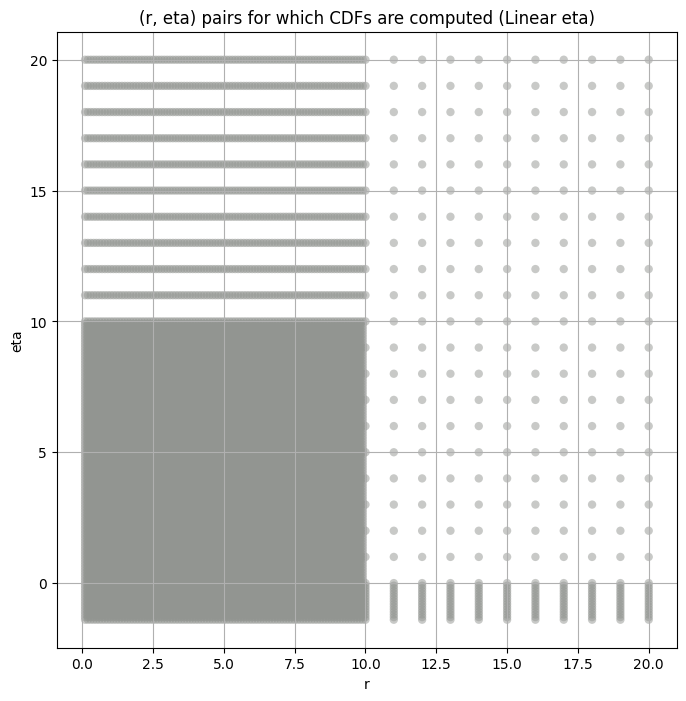

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,83.095370,67.855680,105.233030,71.455246,25.223500,201.95909,7225280.0
3,31.354197,25.858072,41.041767,80.993710,21.976780,296.53674,7225280.0
4,20.954084,16.831034,28.747263,110.533830,29.207600,413.64423,7225280.0
5,11.223501,8.338002,20.151466,398.395600,40.720660,1252.02470,28901120.0
6,3.142441,2.239151,6.361289,635.701300,43.524742,1749.60560,14450560.0
7,0.802050,0.597181,1.434407,389.129640,38.328990,1227.60790,14450560.0
8,0.310199,0.229008,0.548214,370.670070,43.896652,1182.51530,14450560.0
9,0.195227,0.138881,0.294189,220.667160,72.026210,636.45260,14676350.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,83.095370,83.095367,72.050133,67.432571,64.140961,61.529625,57.465607,54.314728,51.719227,49.509346,47.580433,42.911682
3,31.354197,31.354197,27.376858,25.820879,24.674778,23.750601,22.285320,21.127510,20.161057,19.328224,18.597042,16.814035
4,20.954084,20.954084,18.058598,16.882915,16.006325,15.287522,14.137128,13.231064,12.480706,11.841876,11.286616,9.958583
5,11.223501,11.223501,9.012122,8.307969,7.782333,7.355782,6.678281,6.147780,5.711759,5.341899,5.021902,4.266853
6,3.142441,3.142441,2.416091,2.213051,2.064875,1.946082,1.760650,1.617335,1.500674,1.402646,1.318305,1.120757
7,0.802050,0.802050,0.644925,0.596024,0.559788,0.530339,0.483434,0.446600,0.416255,0.390540,0.368289,0.315664
8,0.310199,0.310199,0.249247,0.228672,0.213295,0.200819,0.181126,0.165834,0.153380,0.142948,0.134017,0.113397
9,0.195227,0.195227,0.152079,0.134269,0.121590,0.111690,0.096750,0.085734,0.077164,0.070257,0.064553,0.052108


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.0065880989047830685 83.09537


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.008608333949226638 72.05013


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.006732680036381944 67.43257


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.005393161610981023 64.14096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.004809738049408874 61.529625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.005932976189017072 57.465607


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.0051827079691271205 54.314728


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.005807168185012868 51.719227


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.007132342729795058 49.509346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.008473612641701385 47.580433


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.008574600572912046 42.911682
Number of samples: 100000, Without approximation : 7225280.0


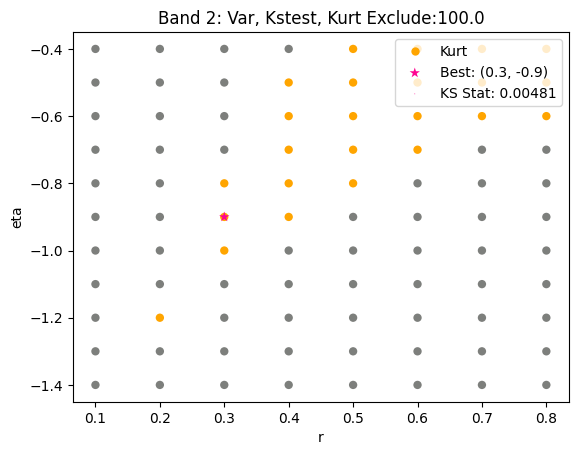

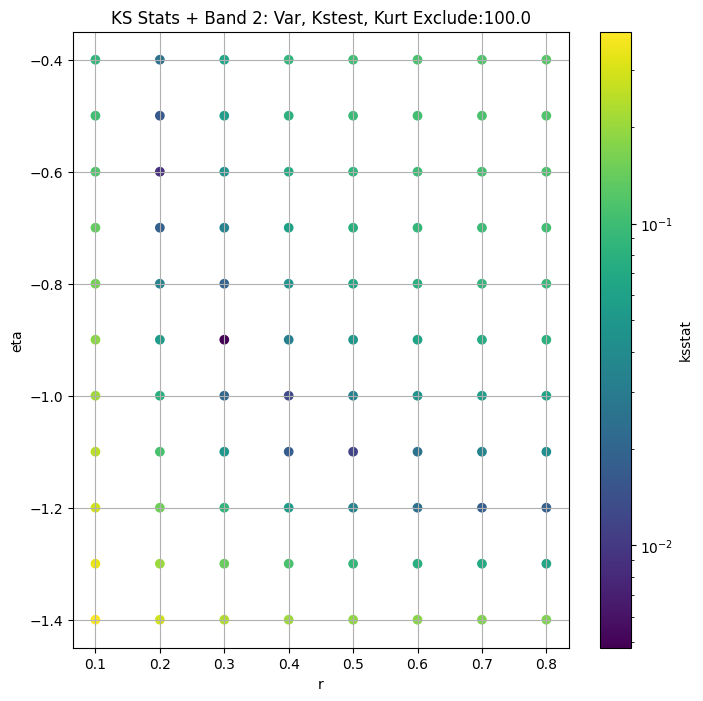

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.004055064288945032 31.354197


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.006871835473278742 27.376858


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.00914432390157649 25.820879


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.009786267445080266 24.674778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.008720445875494698 23.7506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.005008203980692794 22.28532


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.003786182883848903 21.12751


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.004874602250142728 20.161057


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.006205590768895021 19.328224


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.007736530920695386 18.597042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.00857823568335004 16.814035
Number of samples: 100000, Without approximation : 7225280.0


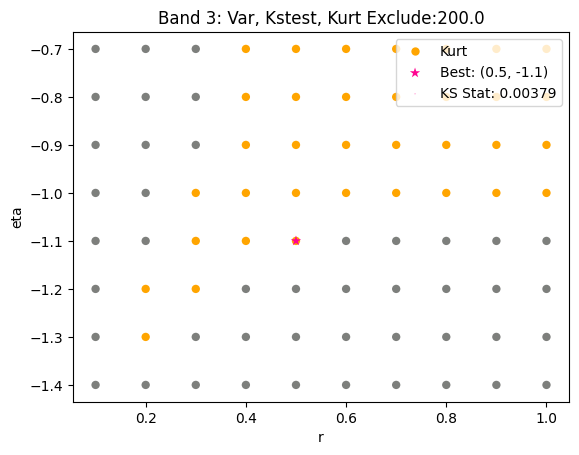

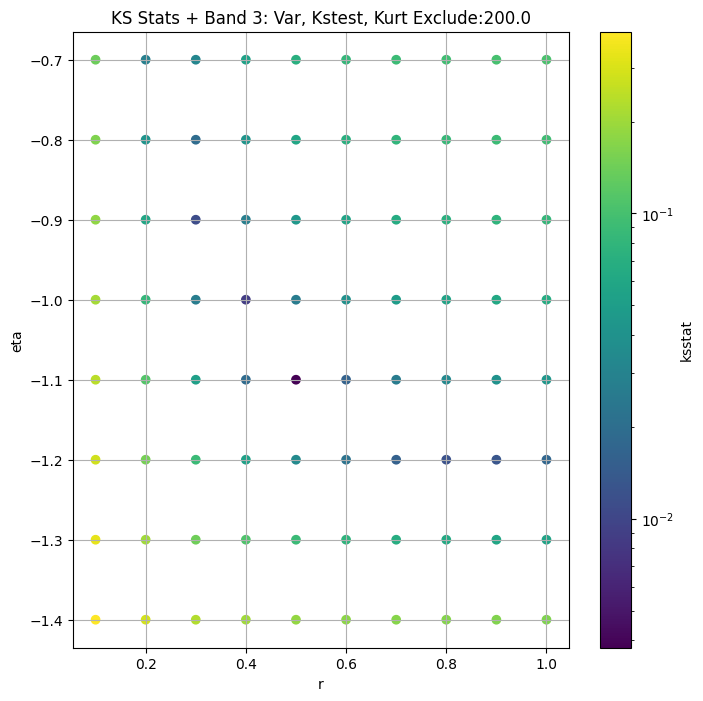

####
Band  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.006590170047321153 20.954084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.00857262857087282 18.058598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.011621202017002397 16.882915


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.010423165311866489 16.006325


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.009315999845397993 15.287522


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.01017598329050784 14.137128


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.007926971548245287 13.231064


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.006824830373988344 12.480706


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.005773782247382286 11.841876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.006861226611447103 11.286616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.010950367283905138 9.958583
Number of samples: 100000, Without approximation : 7225280.0


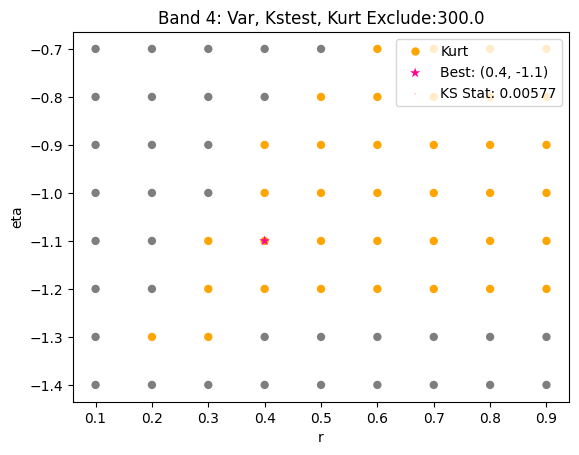

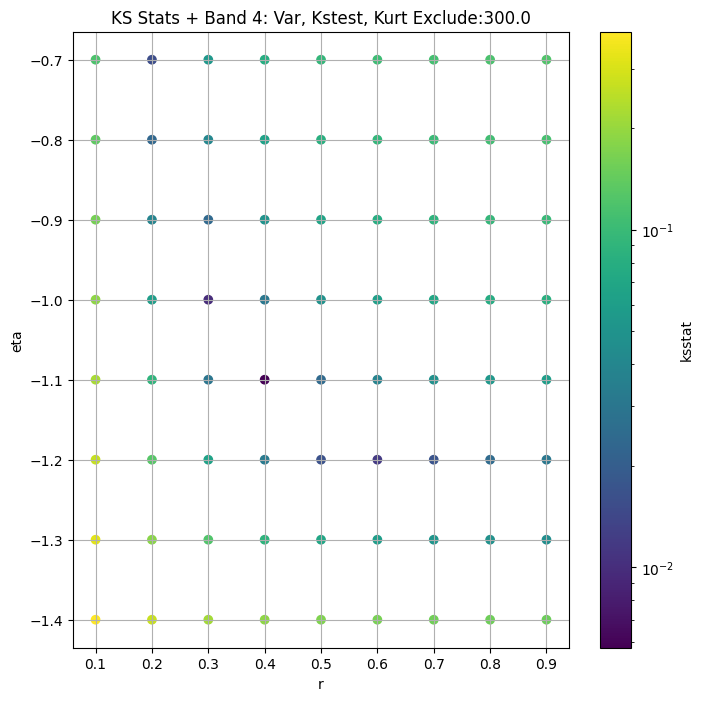

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.00753197523507021 11.223501


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.008513813832599304 9.012122


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.008480648738866114 8.307969


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.006843855597695736 7.782333


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.005388236450458717 7.355782


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.006888410177023296 6.6782813


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.008567228385394032 6.1477804


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.008149968691340548 5.7117586


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.006803851766154025 5.3418994


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.007693296228455222 5.0219016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.008584674561038175 4.2668533
Number of samples: 100000, Without approximation : 28901120.0


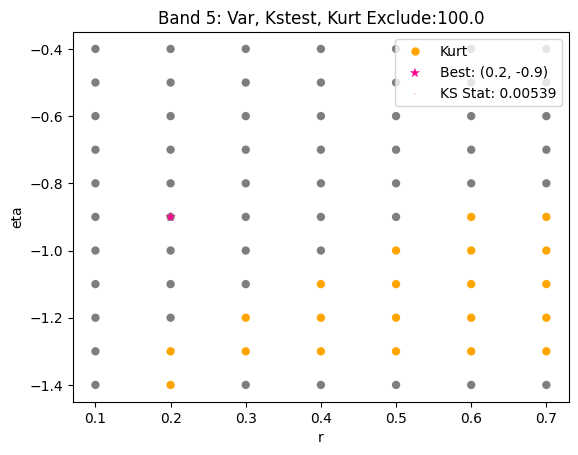

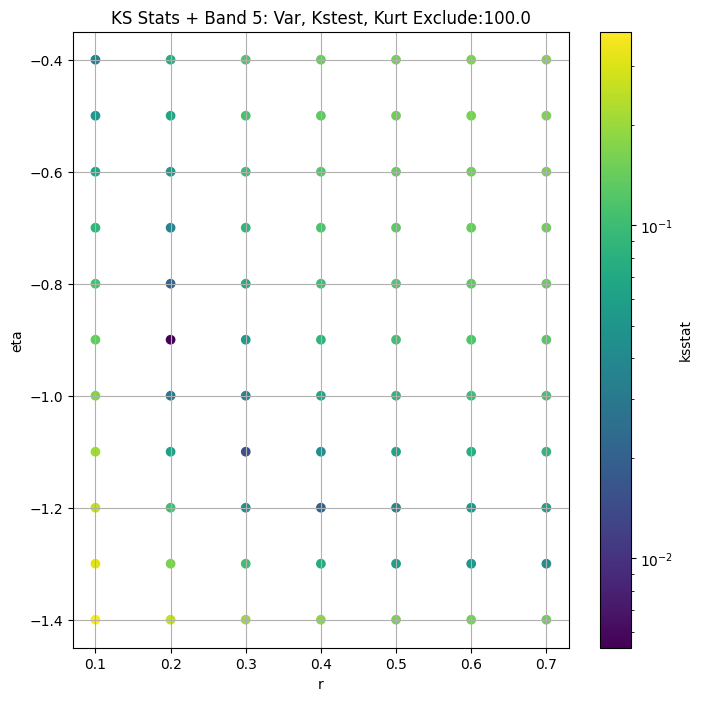

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.008307877042430523 3.1424406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.005327320718632067 2.4160912


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.008342916008505008 2.2130506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.00646086067204843 2.064875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.006336512656326343 1.9460815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.008752232223513512 1.76065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.004945972061501446 1.6173348


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.005818963558958813 1.5006735


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.008972804387426259 1.4026463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.006862676705235438 1.3183054


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.008458522573922935 1.1207567
Number of samples: 100000, Without approximation : 14450560.0


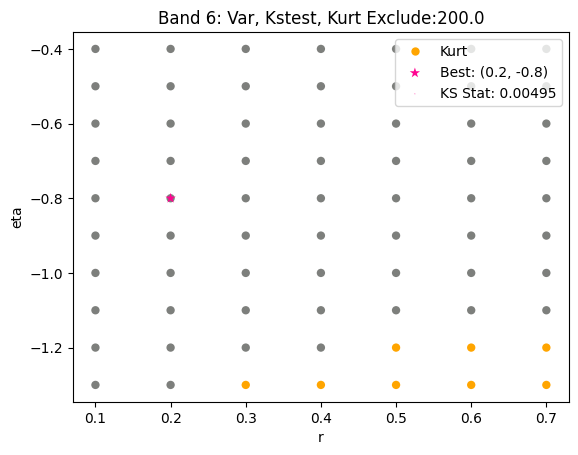

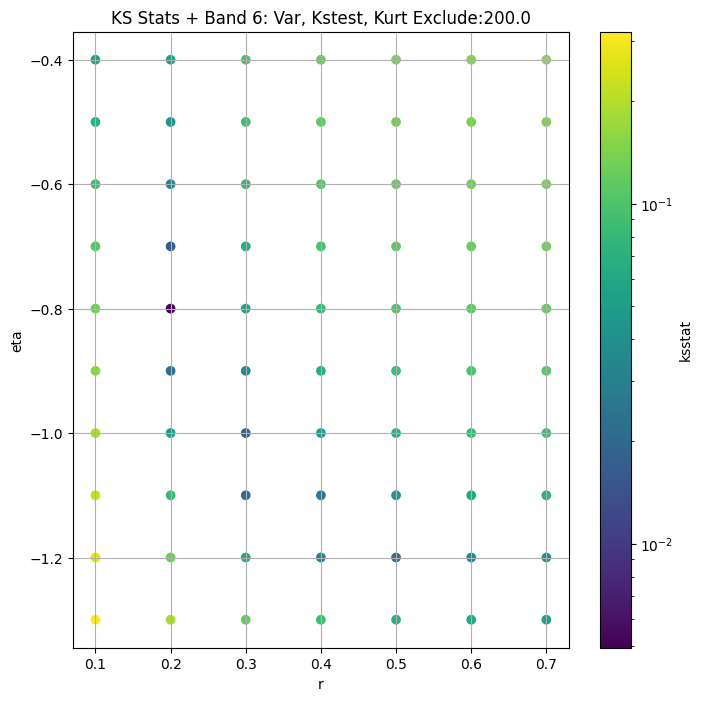

####
Band  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.006137588490154111 0.80205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.006407766866358688 0.6449246


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.004184345217077667 0.5960237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.004323252291771856 0.55978763


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.006131126804308273 0.5303386


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.005263000827616042 0.48343438


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.006775184740251294 0.44660008


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.005496421364899841 0.41625494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.00631068590897341 0.39054


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.0071674081841531685 0.3682887


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.008212709031149783 0.31566423
Number of samples: 100000, Without approximation : 14450560.0


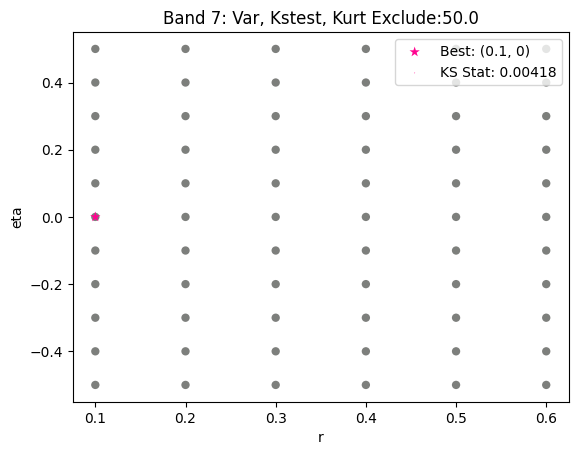

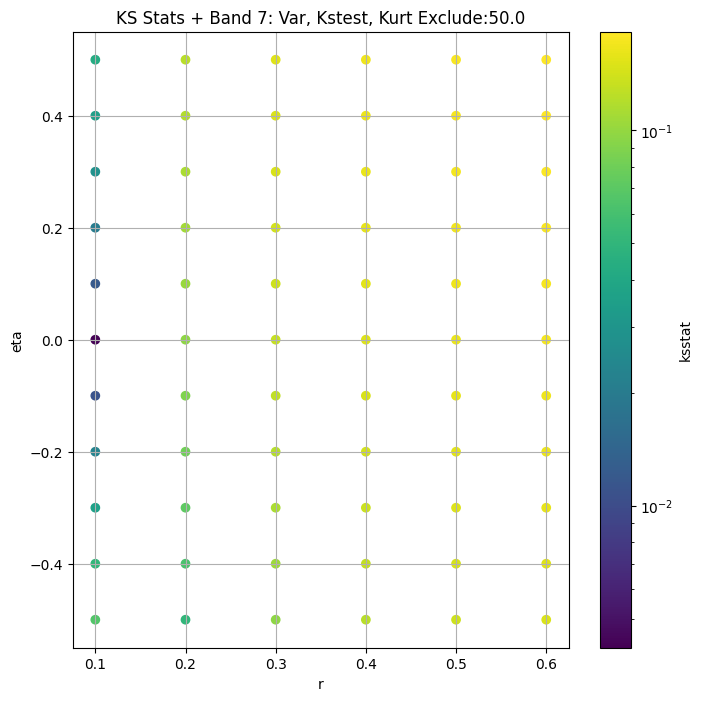

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.00990924060423004 0.31019884


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.008515475454069499 0.24924721


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.004420070196140102 0.22867168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.00584578202441377 0.21329486


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.003278640495898027 0.2008187


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0046650846659686 0.181126


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.005012219253548658 0.16583408


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.005447376229540168 0.1533801


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006707549611686278 0.14294776


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.006213736123425908 0.13401662


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.007671344815578067 0.11339716
Number of samples: 100000, Without approximation : 14450560.0


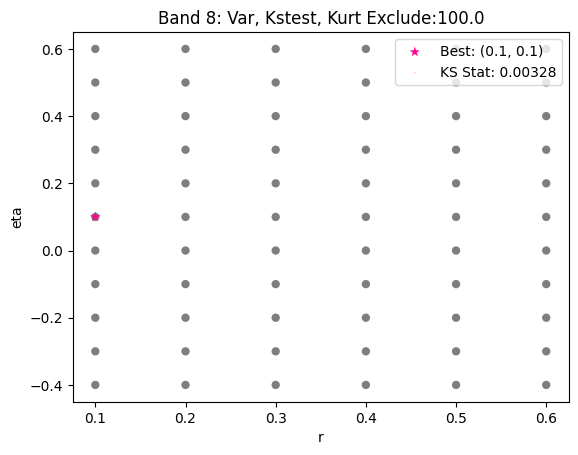

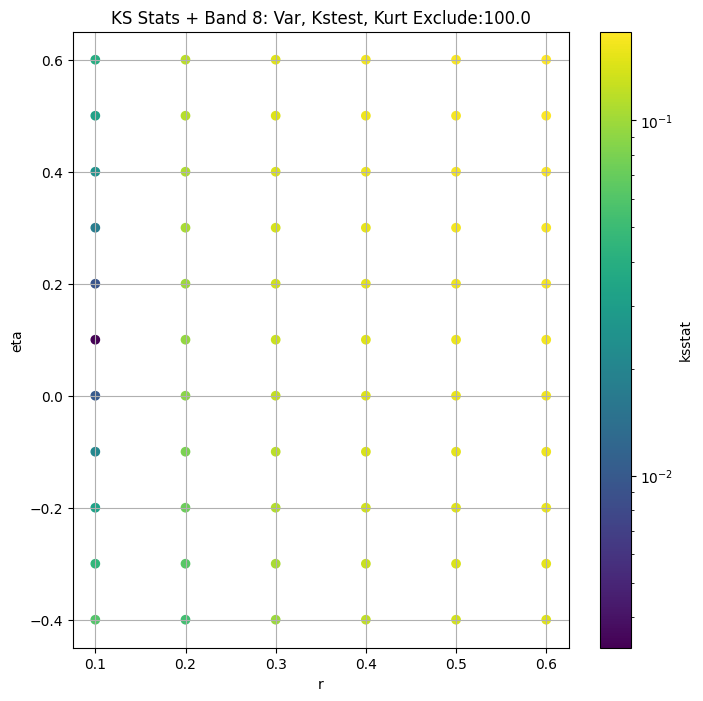

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.011531577341516053 0.19522709


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.008346817885257929 0.15207896


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.008012399511083235 0.1342686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.008011671788374697 0.121590264


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.011132491056918603 0.11168967


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.008010316162043174 0.096749574


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.00800999999960783 0.08573432


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.011515068619608548 0.07716394


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.008478268001016365 0.07025679


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.008011586624371292 0.064553365


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.008009999999301132 0.052107956
Number of samples: 100000, Without approximation : 14676350.0


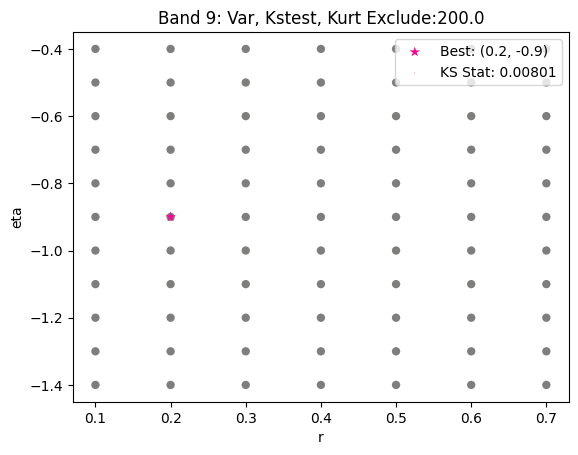

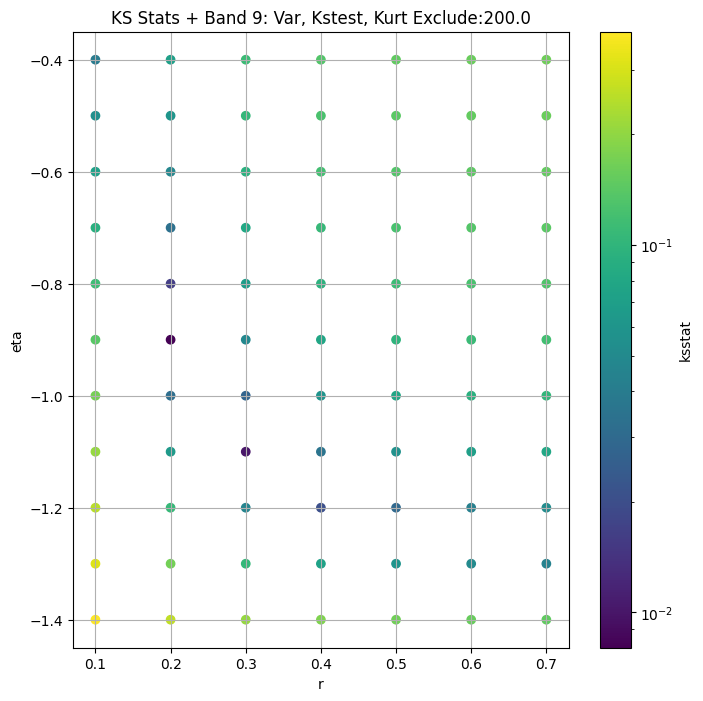

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,83.095370,67.855680,105.233030,71.455246,25.223500,201.95909,7225280.0,0.004810,0.3,-0.9,1.533297e+00,100.0,61.529625,0.000505
3,31.354197,25.858072,41.041767,80.993710,21.976780,296.53674,7225280.0,0.003786,0.5,-1.1,1.467188e+01,200.0,21.127510,0.000505
4,20.954084,16.831034,28.747263,110.533830,29.207600,413.64423,7225280.0,0.005774,0.4,-1.1,3.563234e+00,300.0,11.841876,0.000505
5,11.223501,8.338002,20.151466,398.395600,40.720660,1252.02470,28901120.0,0.005388,0.2,-0.9,2.918961e-03,100.0,7.355782,0.000253
6,3.142441,2.239151,6.361289,635.701300,43.524742,1749.60560,14450560.0,0.004946,0.2,-0.8,3.829853e-04,200.0,1.617335,0.000357
7,0.802050,0.597181,1.434407,389.129640,38.328990,1227.60790,14450560.0,0.004184,0.1,0.0,8.374641e-14,50.0,0.596024,0.000357
8,0.310199,0.229008,0.548214,370.670070,43.896652,1182.51530,14450560.0,0.003279,0.1,0.1,1.693004e-14,100.0,0.200819,0.000357
9,0.195227,0.138881,0.294189,220.667160,72.026210,636.45260,14676350.0,0.008010,0.2,-0.9,3.402156e-05,200.0,0.085734,0.000354


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 100.0 + 100 = 200, ksstat: 0.004606668733677911, var: 54.314727783203125


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 100.0 + 75 = 175, ksstat: 0.00401708119991696, var: 55.80520248413086


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 100.0 + 50 = 150, ksstat: 0.003397511918407623, var: 57.465606689453125


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 100.0 + 25 = 125, ksstat: 0.002776674418710986, var: 59.34775924682617


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 100.0 + 0 = 100, ksstat: 0.002444370270922102, var: 61.529624938964844


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 100.0 + -25 = 75, ksstat: 0.0022132626523175825, var: 64.14096069335938


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 100.0 + -50 = 50, ksstat: 0.0023441767567666805, var: 67.43257141113281


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 100.0 + -75 = 25, ksstat: 0.0022738300513387433, var: 72.05013275146484


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 2, 100.0 + -100 = 0, ksstat: 0.003779152971960409, var: 83.09536743164062
Number of samples: 100000, Without approximation : 7225280.0


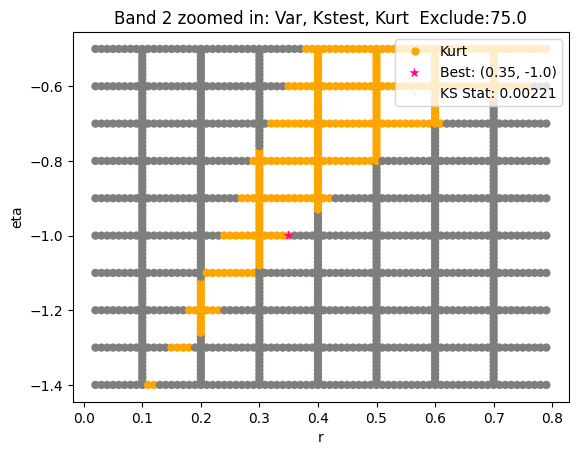

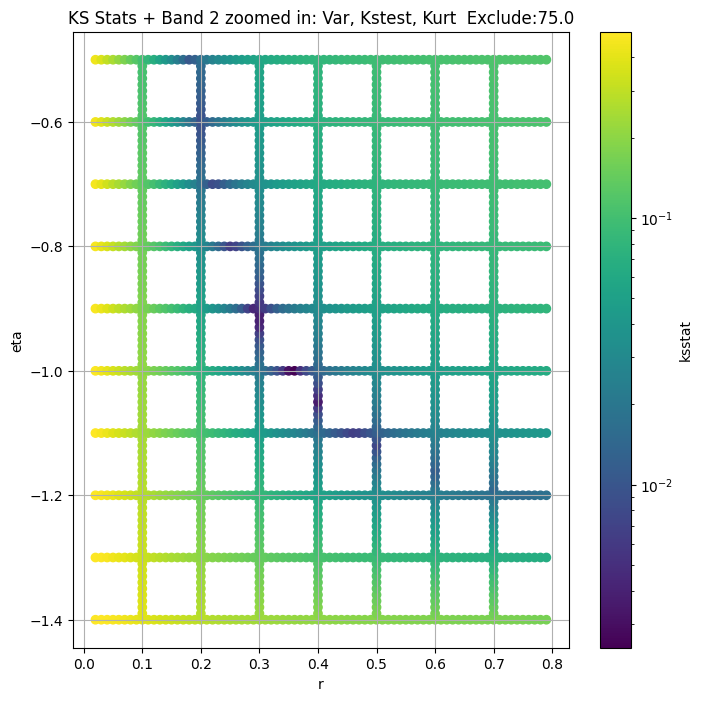

Band 3


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 200.0 + 100 = 300, ksstat: 0.005130454735980009, var: 19.328224182128906


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 200.0 + 75 = 275, ksstat: 0.004718044832296365, var: 19.73035430908203


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 200.0 + 50 = 250, ksstat: 0.004562946118924587, var: 20.161056518554688


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 200.0 + 25 = 225, ksstat: 0.004152740553889877, var: 20.624784469604492


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 200.0 + 0 = 200, ksstat: 0.003736605061519547, var: 21.12751007080078


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 200.0 + -25 = 175, ksstat: 0.0033064488992842807, var: 21.677509307861328


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 200.0 + -50 = 150, ksstat: 0.002909989323772417, var: 22.285320281982422


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 200.0 + -75 = 125, ksstat: 0.002597918104776775, var: 22.96814727783203


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
band 3, 200.0 + -100 = 100, ksstat: 0.0022360146345744604, var: 23.750600814819336
Number of samples: 100000, Without approximation : 7225280.0


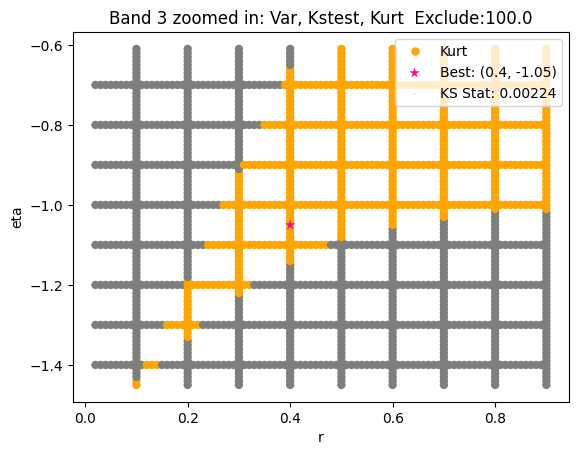

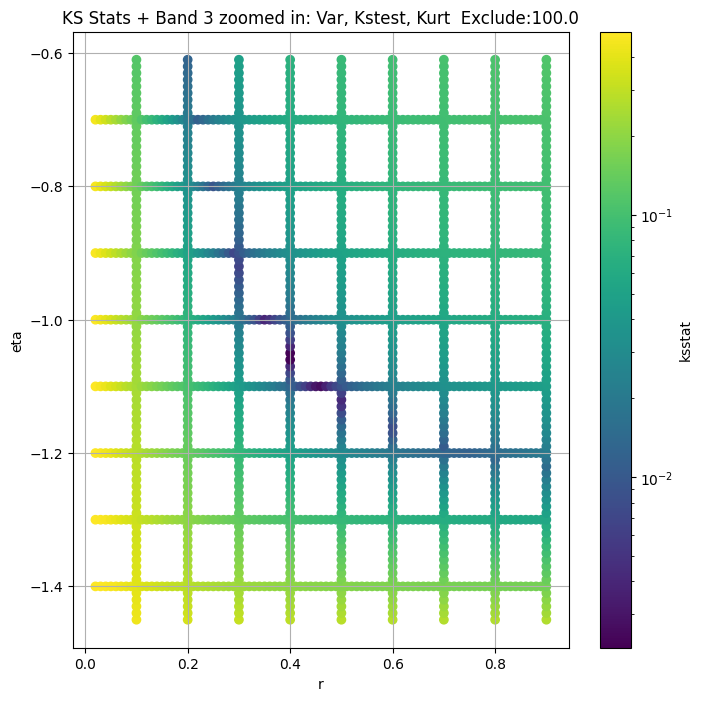

Band 4


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 300.0 + 100 = 400, ksstat: 0.006687701774146303, var: 10.795585632324219


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 300.0 + 75 = 375, ksstat: 0.006304661272516117, var: 11.033919334411621


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 300.0 + 50 = 350, ksstat: 0.006351383860886406, var: 11.286616325378418


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 300.0 + 25 = 325, ksstat: 0.006102977556626154, var: 11.555187225341797


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 300.0 + 0 = 300, ksstat: 0.005773782247382286, var: 11.841876029968262


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 300.0 + -25 = 275, ksstat: 0.005341660589095378, var: 12.149235725402832


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 300.0 + -50 = 250, ksstat: 0.004864192487833582, var: 12.480706214904785


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 300.0 + -75 = 225, ksstat: 0.004580391769107742, var: 12.839714050292969


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 300.0 + -100 = 200, ksstat: 0.004318869510758938, var: 13.231063842773438
Number of samples: 100000, Without approximation : 7225280.0


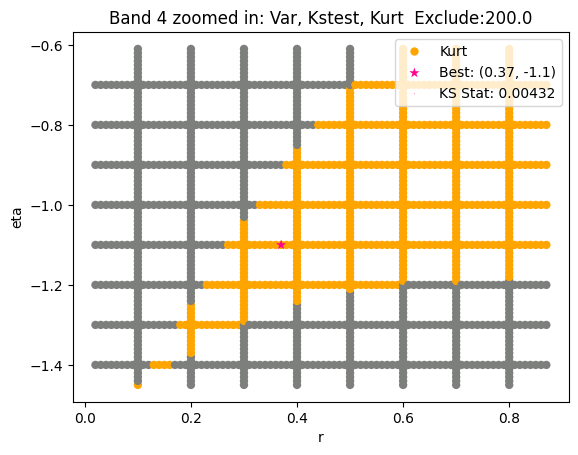

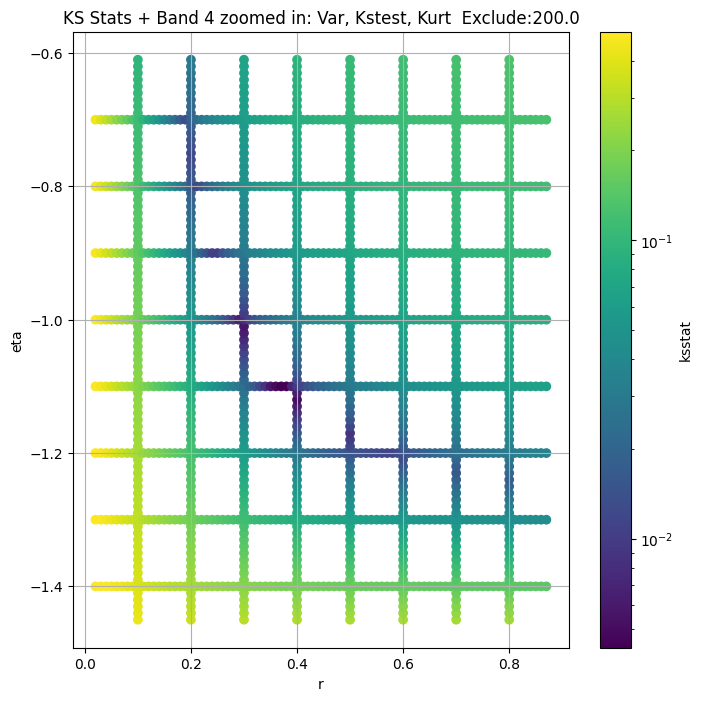

Band 5


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.004959562495962966, var: 6.147780418395996


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.004739254917735566, var: 6.398812294006348


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.004392677399746069, var: 6.678281307220459


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.004140180344381461, var: 6.993778228759766


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.004369924694793647, var: 7.3557820320129395


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.0034324652971792213, var: 7.782332897186279


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.003702170602349633, var: 8.307969093322754


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.0032459527764570617, var: 9.01212215423584


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.007748610107900289, var: 11.223501205444336
Number of samples: 100000, Without approximation : 28901120.0


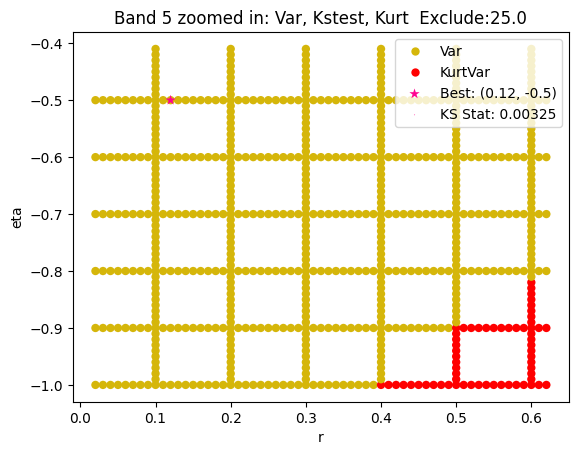

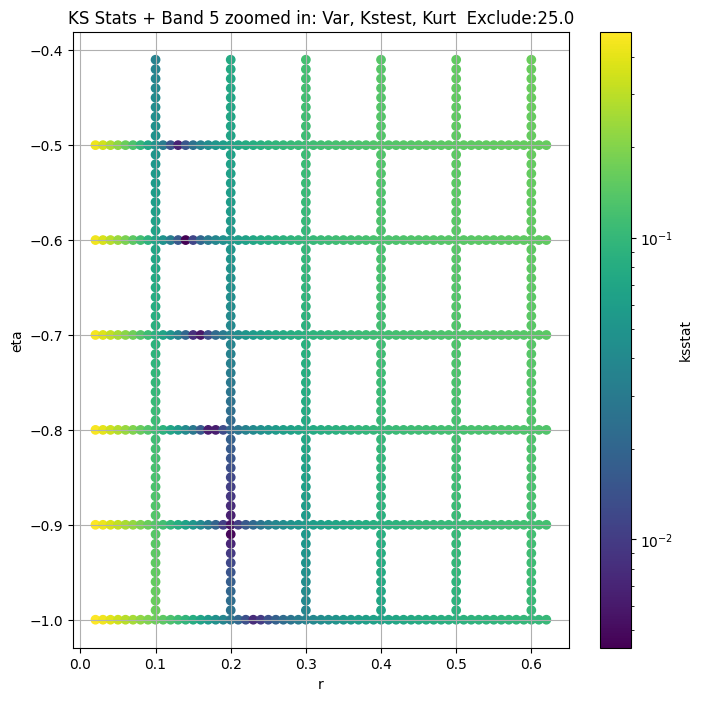

Band 6


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 6, 200.0 + 100 = 300, ksstat: 0.006139019430338141, var: 1.4026463031768799


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 6, 200.0 + 75 = 275, ksstat: 0.005752202398504795, var: 1.4496657848358154


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 6, 200.0 + 50 = 250, ksstat: 0.00551225465401234, var: 1.500673532485962


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 6, 200.0 + 25 = 225, ksstat: 0.005100789937424447, var: 1.5562995672225952


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 6, 200.0 + 0 = 200, ksstat: 0.004945972061501446, var: 1.6173348426818848


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 6, 200.0 + -25 = 175, ksstat: 0.004562028831342671, var: 1.6849645376205444


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 6, 200.0 + -50 = 150, ksstat: 0.004456518367852455, var: 1.7606500387191772


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 6, 200.0 + -75 = 125, ksstat: 0.00470046991687828, var: 1.8465648889541626


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 6, 200.0 + -100 = 100, ksstat: 0.004359105995127899, var: 1.946081519126892
Number of samples: 100000, Without approximation : 14450560.0


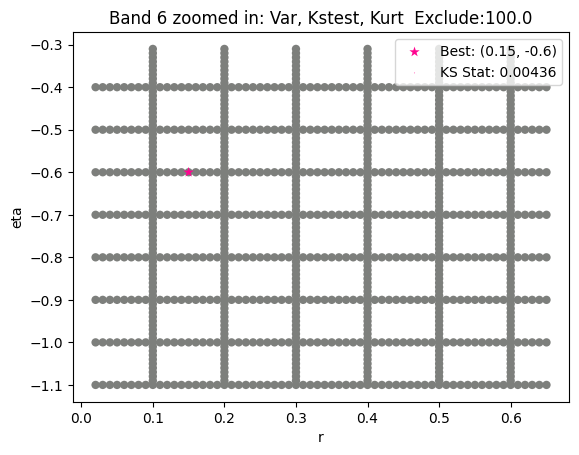

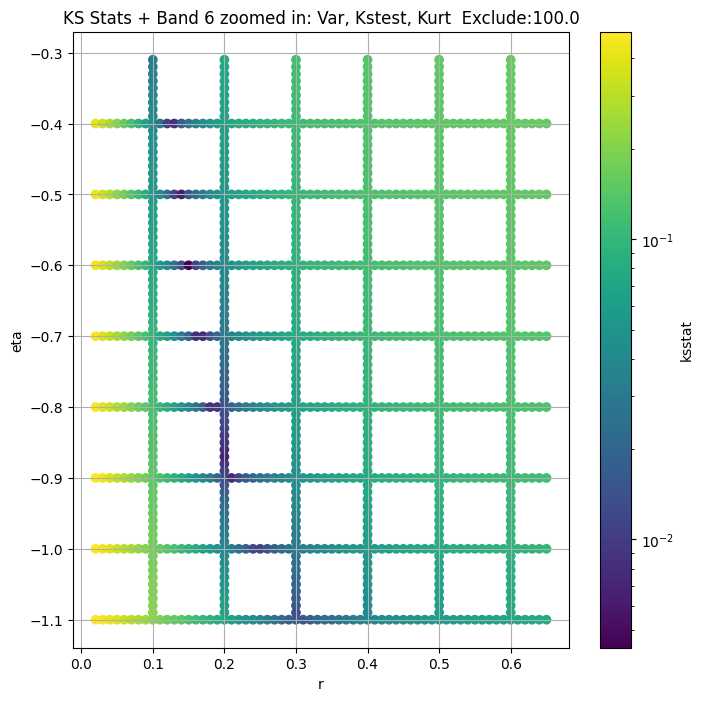

Band 7


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 7, 50.0 + 100 = 150, ksstat: 0.004573814164082243, var: 0.48343437910079956


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 7, 50.0 + 75 = 125, ksstat: 0.0040756055335035655, var: 0.5052867531776428


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 7, 50.0 + 50 = 100, ksstat: 0.004050796794892286, var: 0.5303385853767395


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 7, 50.0 + 25 = 75, ksstat: 0.003883703417758337, var: 0.5597876310348511


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 7, 50.0 + 0 = 50, ksstat: 0.002849334764244201, var: 0.596023678779602


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 7, 50.0 + -25 = 25, ksstat: 0.003058566484038683, var: 0.6449245810508728


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 7, 50.0 + -50 = 0, ksstat: 0.0047697781330885425, var: 0.802049994468689
Number of samples: 100000, Without approximation : 14450560.0


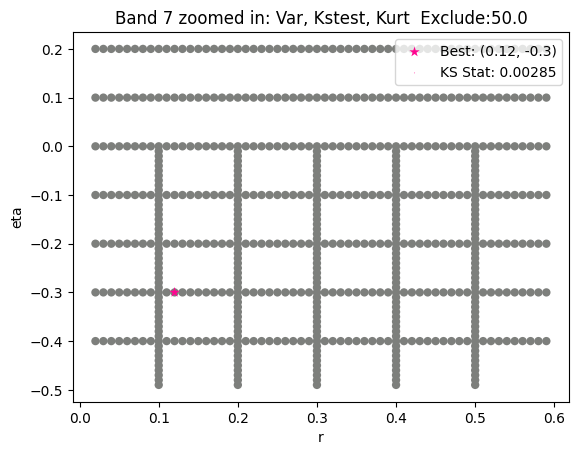

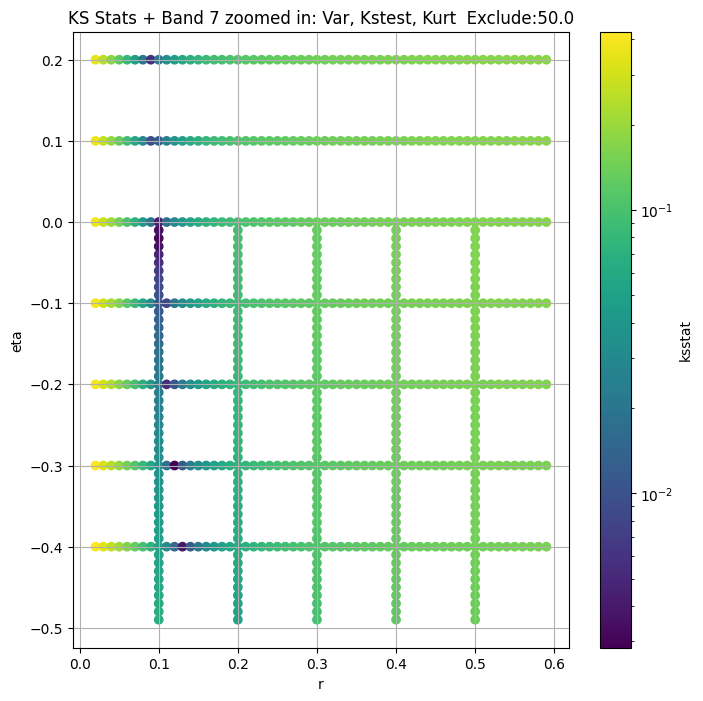

Band 8


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 100.0 + 100 = 200, ksstat: 0.0045112382143079, var: 0.16583408415317535


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 100.0 + 75 = 175, ksstat: 0.004297805882931546, var: 0.17304657399654388


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 100.0 + 50 = 150, ksstat: 0.004014695795244215, var: 0.18112599849700928


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 100.0 + 25 = 125, ksstat: 0.003471068992764132, var: 0.19028198719024658


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 100.0 + 0 = 100, ksstat: 0.003278640495898027, var: 0.20081870257854462


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 100.0 + -25 = 75, ksstat: 0.003022125005201593, var: 0.2132948637008667


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 100.0 + -50 = 50, ksstat: 0.003980595111280905, var: 0.22867168486118317


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 100.0 + -75 = 25, ksstat: 0.005469731403570932, var: 0.249247208237648


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 8, 100.0 + -100 = 0, ksstat: 0.007324631611388854, var: 0.3101988434791565
Number of samples: 100000, Without approximation : 14450560.0


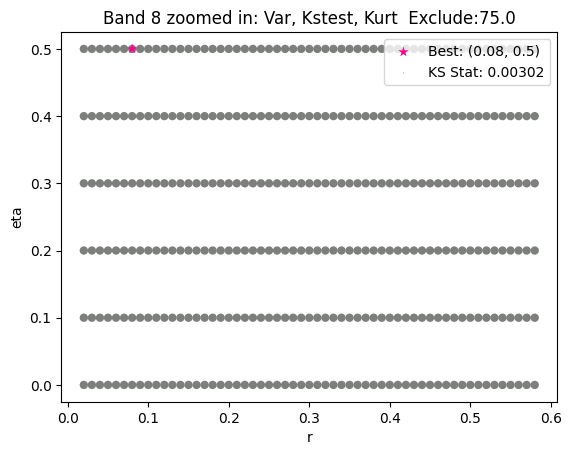

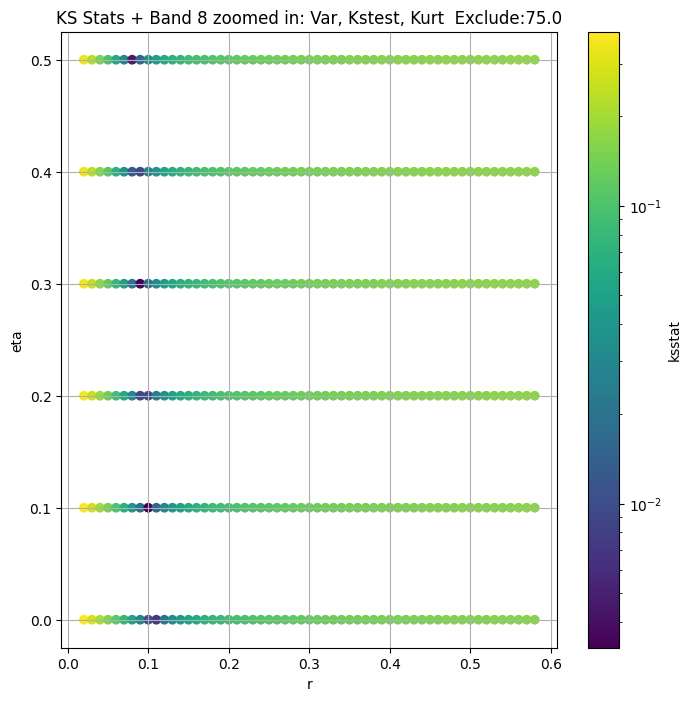

Band 9


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 9, 200.0 + 100 = 300, ksstat: 0.0080099999988969, var: 0.0702567920088768


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 9, 200.0 + 75 = 275, ksstat: 0.00800999999885188, var: 0.07353667169809341


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 9, 200.0 + 50 = 250, ksstat: 0.008009999999170847, var: 0.0771639421582222


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 9, 200.0 + 25 = 225, ksstat: 0.008009999999173567, var: 0.08119889348745346


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 9, 200.0 + 0 = 200, ksstat: 0.00800999999919566, var: 0.08573432266712189


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 9, 200.0 + -25 = 175, ksstat: 0.008009999999126771, var: 0.09086990356445312


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 9, 200.0 + -50 = 150, ksstat: 0.008009999999153694, var: 0.09674957394599915


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 9, 200.0 + -75 = 125, ksstat: 0.008009999999330941, var: 0.10358506441116333


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 9, 200.0 + -100 = 100, ksstat: 0.008009999999307738, var: 0.11168967187404633
Number of samples: 100000, Without approximation : 14676350.0


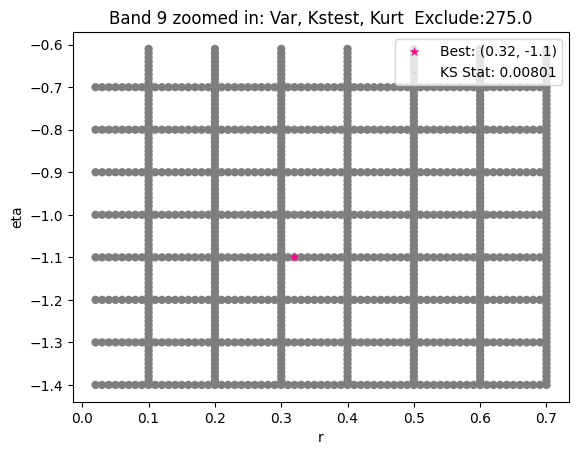

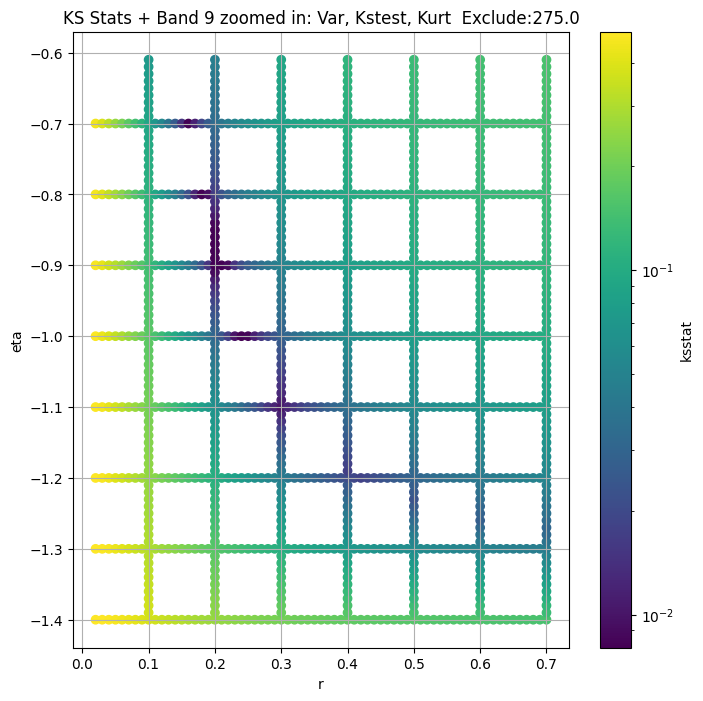

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,83.095370,67.855680,105.233030,71.455246,25.223500,201.95909,7225280.0,0.004810,0.3,-0.9,1.533297e+00,100.0,64.140961,0.000505,0.002213,0.35,-1.00,6.541690e+00,75.0,381019
3,31.354197,25.858072,41.041767,80.993710,21.976780,296.53674,7225280.0,0.003786,0.5,-1.1,1.467188e+01,200.0,23.750601,0.000505,0.002236,0.40,-1.05,5.848411e+00,100.0,381019
4,20.954084,16.831034,28.747263,110.533830,29.207600,413.64423,7225280.0,0.005774,0.4,-1.1,3.563234e+00,300.0,13.231064,0.000505,0.004319,0.37,-1.10,2.756690e+00,200.0,95253
5,11.223501,8.338002,20.151466,398.395600,40.720660,1252.02470,28901120.0,0.005388,0.2,-0.9,2.918961e-03,100.0,9.012122,0.000253,0.003246,0.12,-0.50,1.086366e-08,25.0,169342
6,3.142441,2.239151,6.361289,635.701300,43.524742,1749.60560,14450560.0,0.004946,0.2,-0.8,3.829853e-04,200.0,1.946082,0.000357,0.004359,0.15,-0.60,1.126507e-06,100.0,95253
7,0.802050,0.597181,1.434407,389.129640,38.328990,1227.60790,14450560.0,0.004184,0.1,0.0,8.374641e-14,50.0,0.596024,0.000357,0.002849,0.12,-0.30,2.334655e-10,50.0,225790
8,0.310199,0.229008,0.548214,370.670070,43.896652,1182.51530,14450560.0,0.003279,0.1,0.1,1.693004e-14,100.0,0.213295,0.000357,0.003022,0.08,0.50,5.868366e-20,75.0,203436
9,0.195227,0.138881,0.294189,220.667160,72.026210,636.45260,14676350.0,0.008010,0.2,-0.9,3.402156e-05,200.0,0.073537,0.000354,0.008010,0.32,-1.10,6.803391e-03,275.0,28664


In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

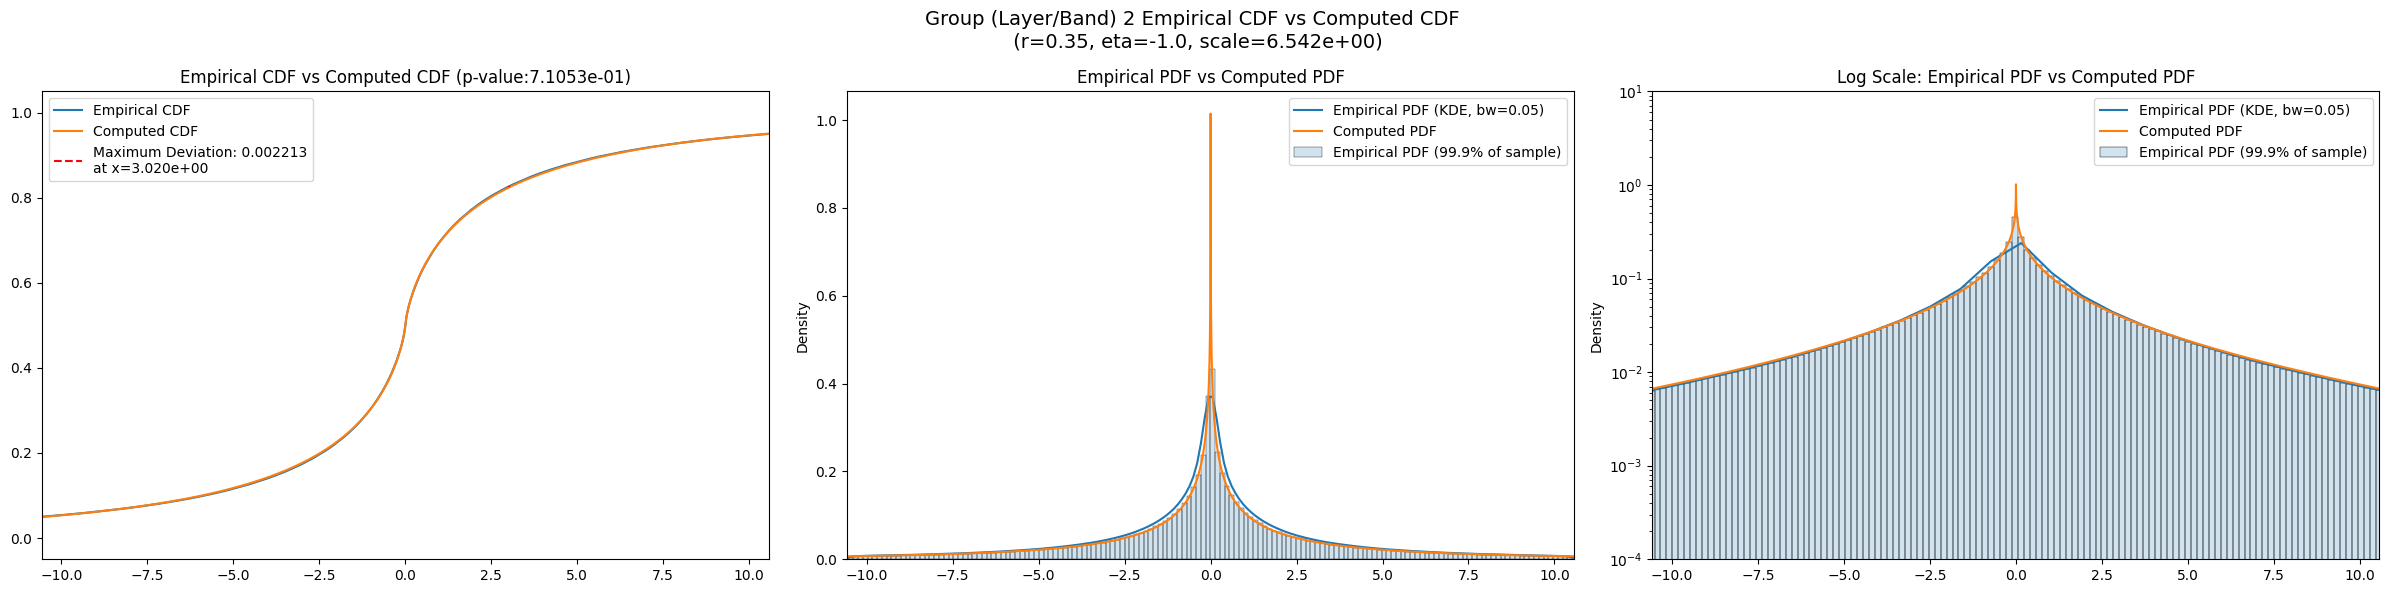

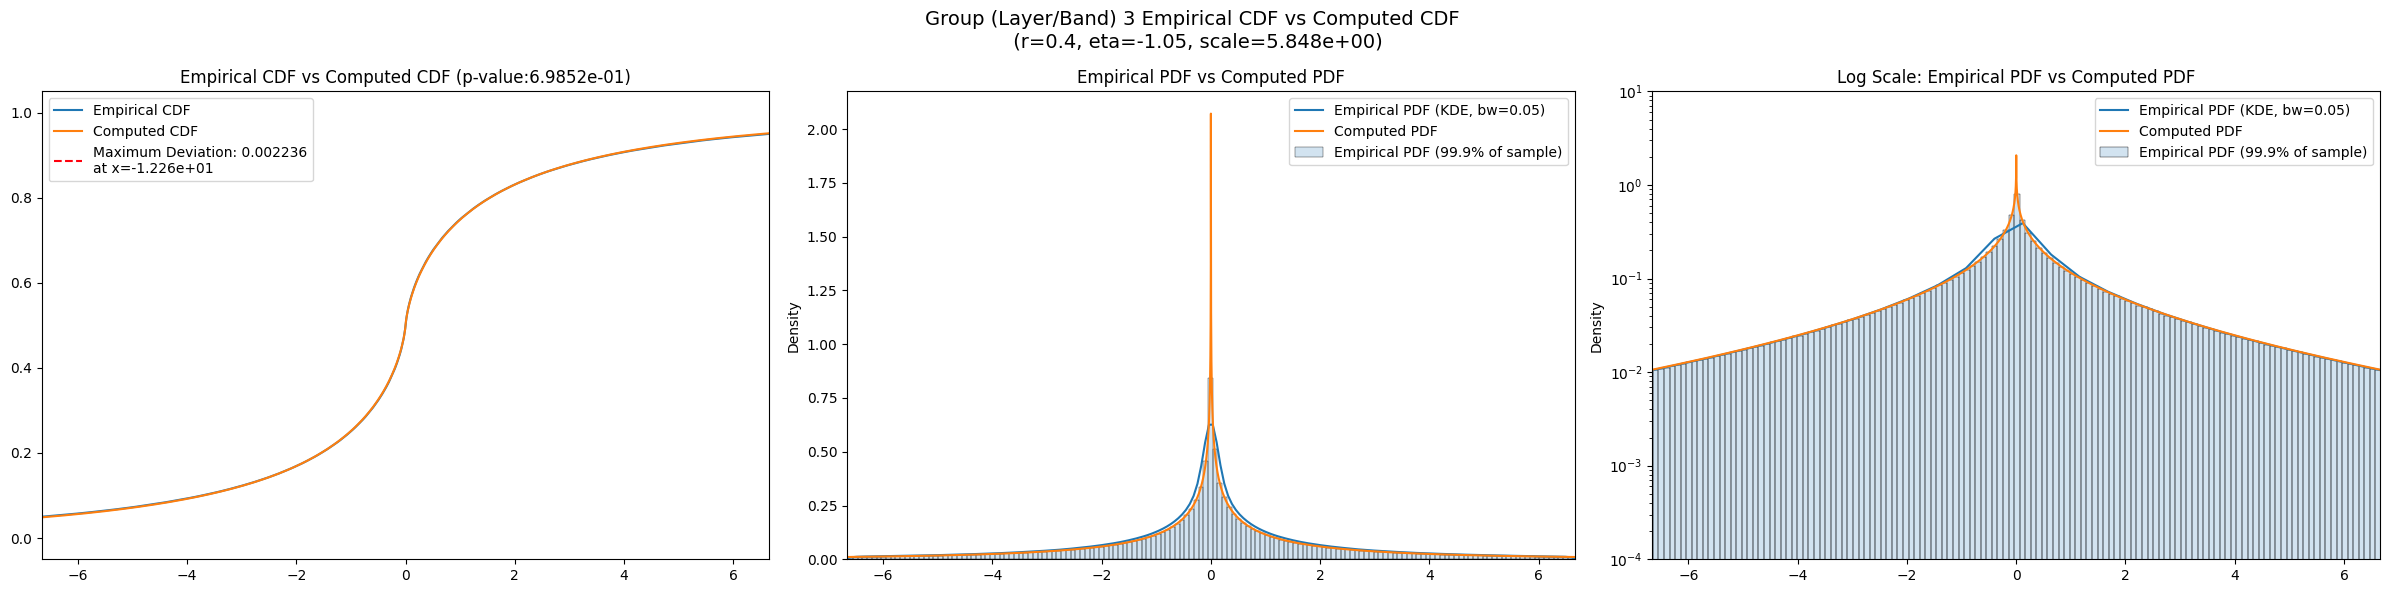

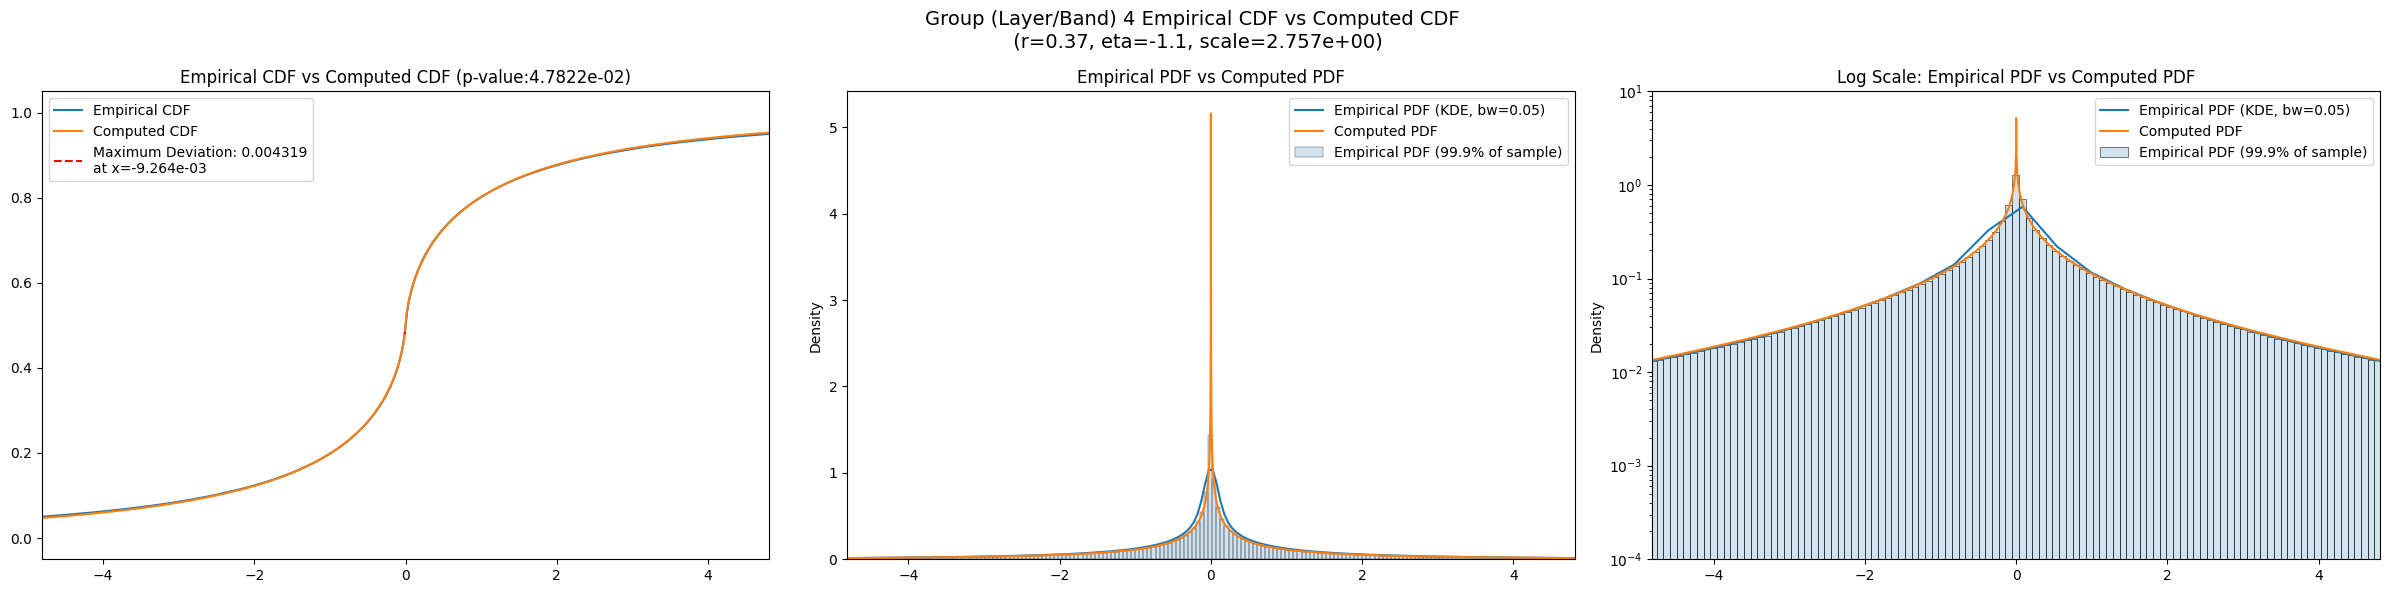

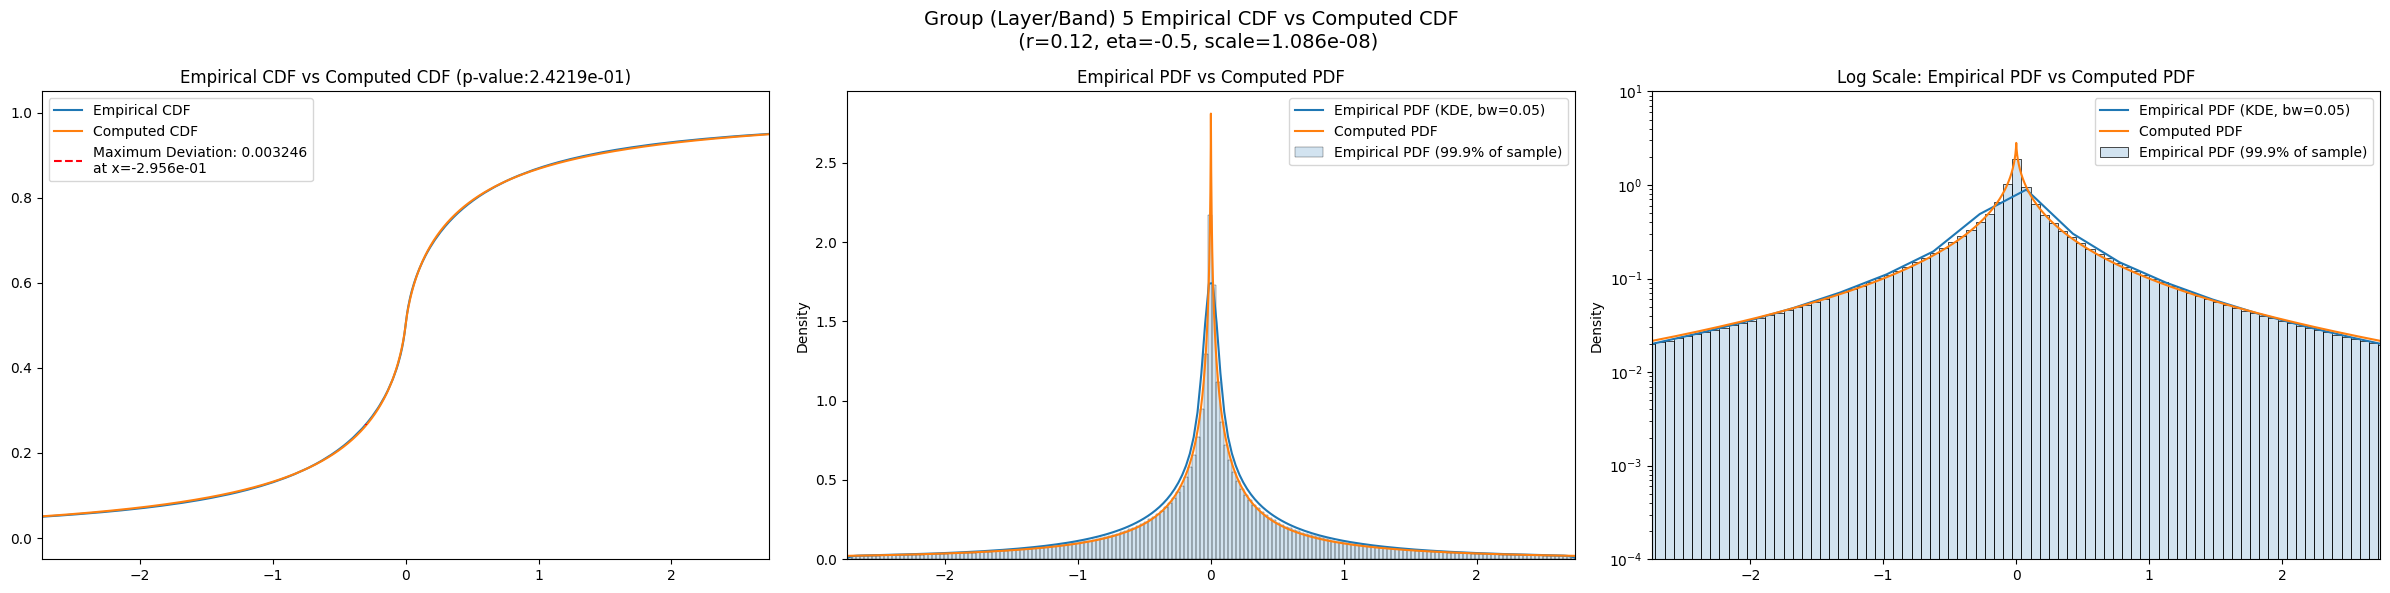

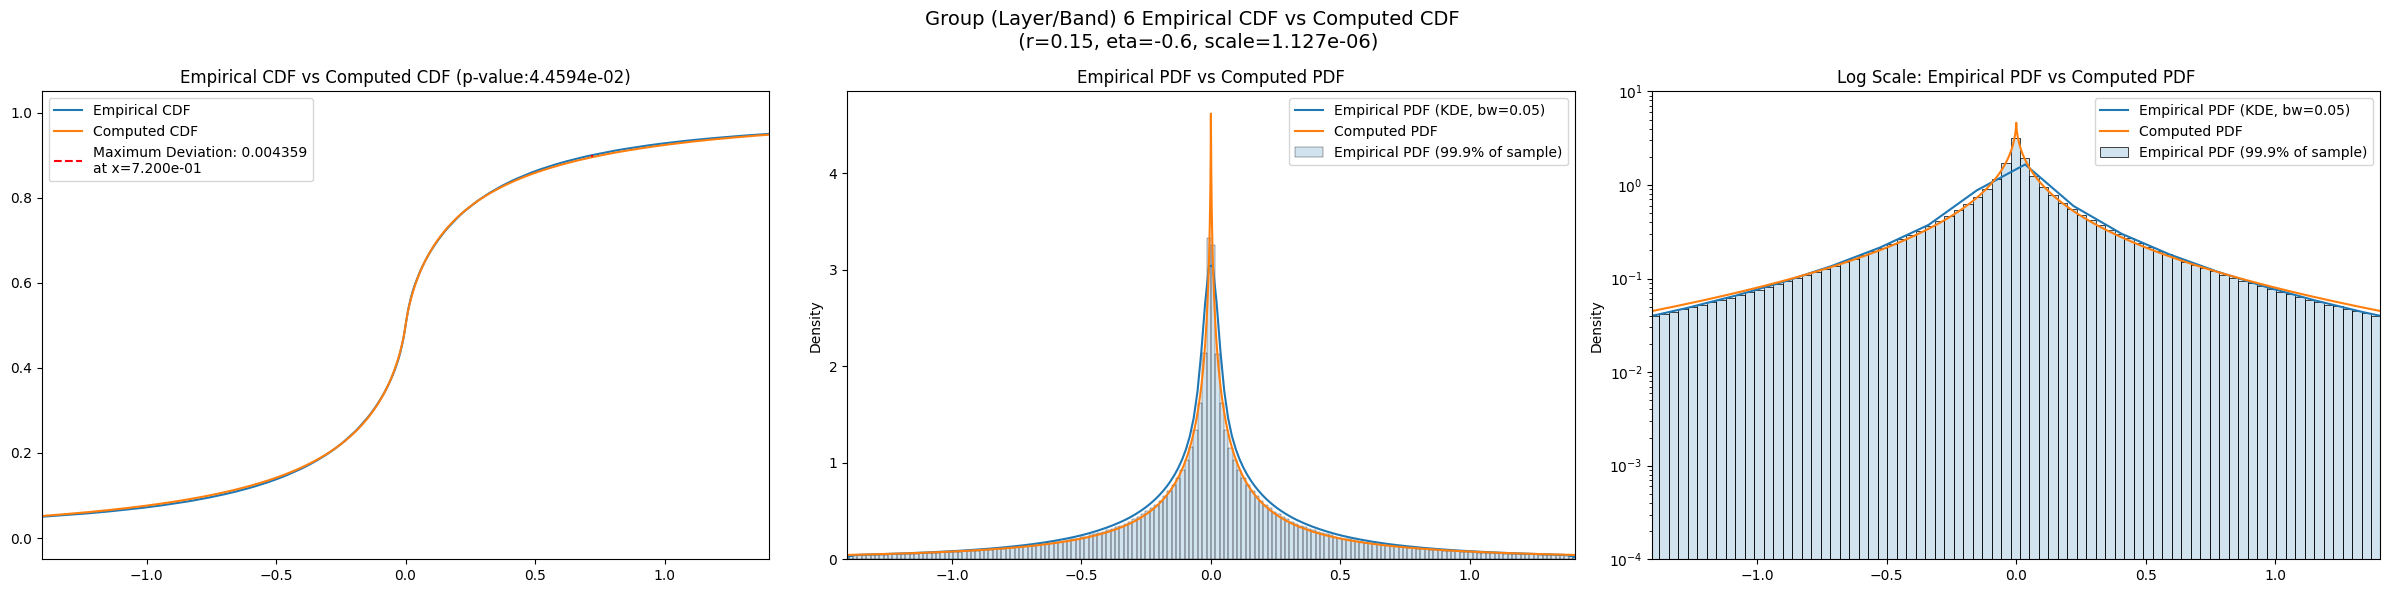

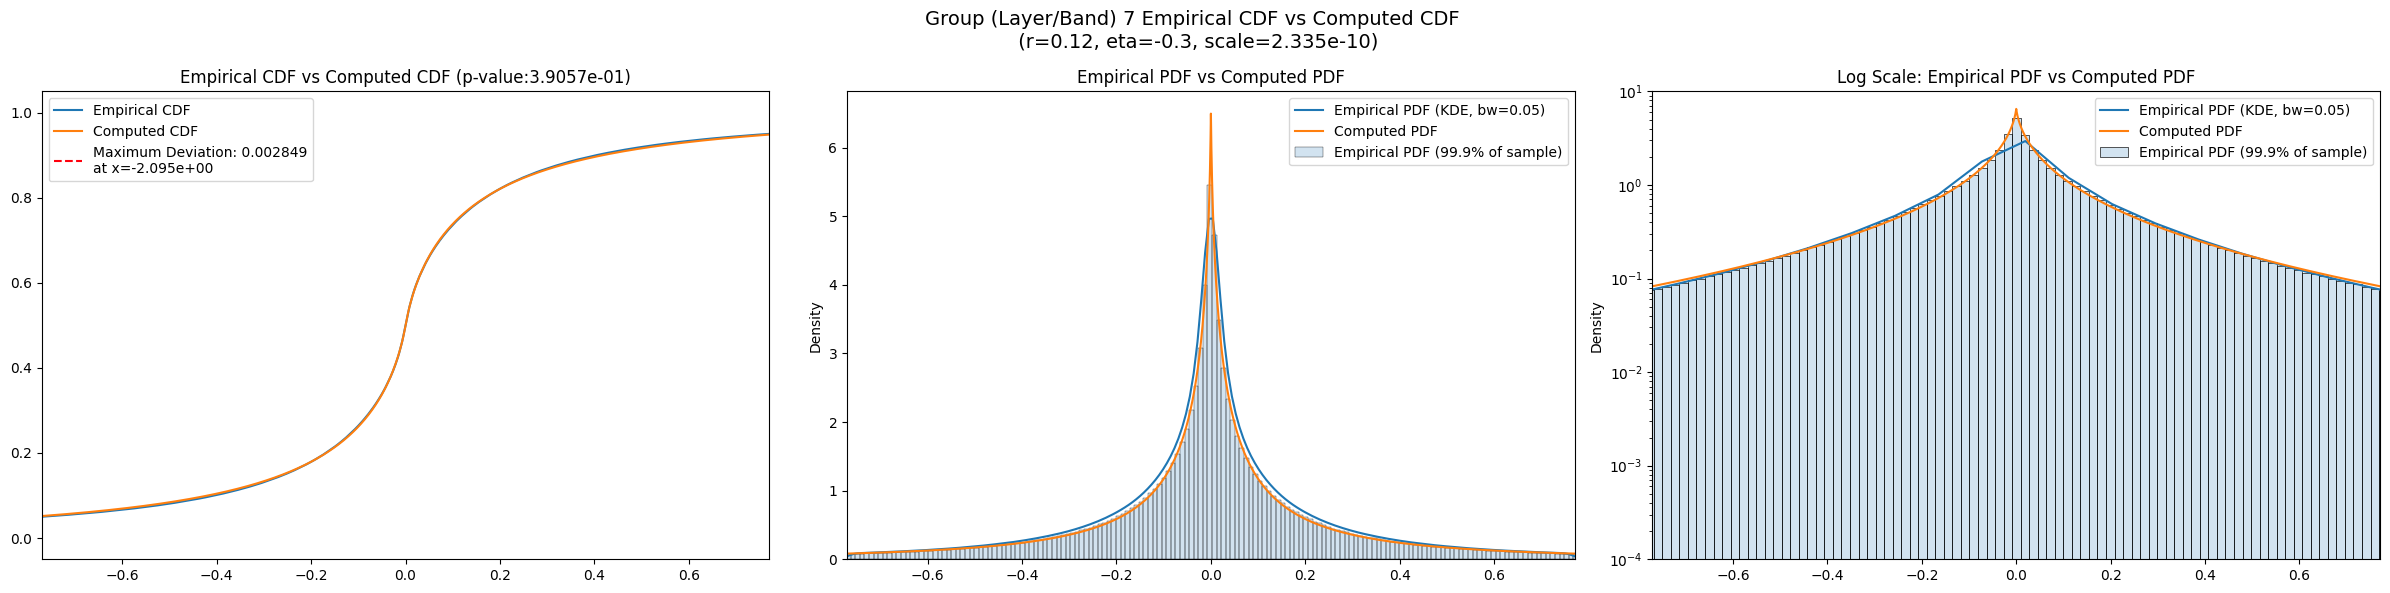

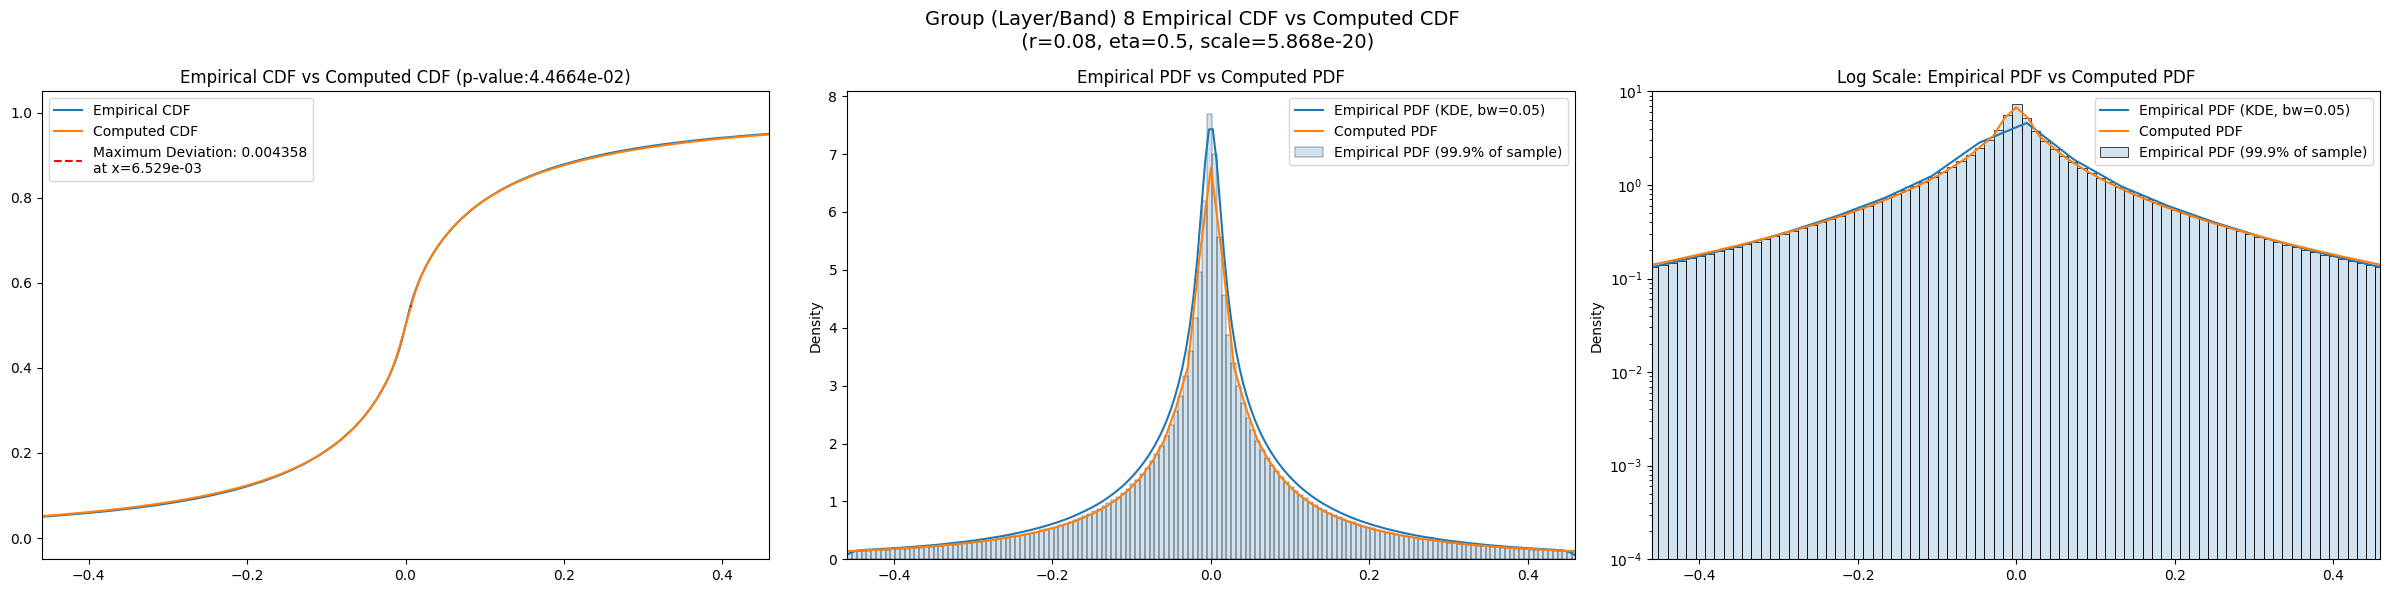

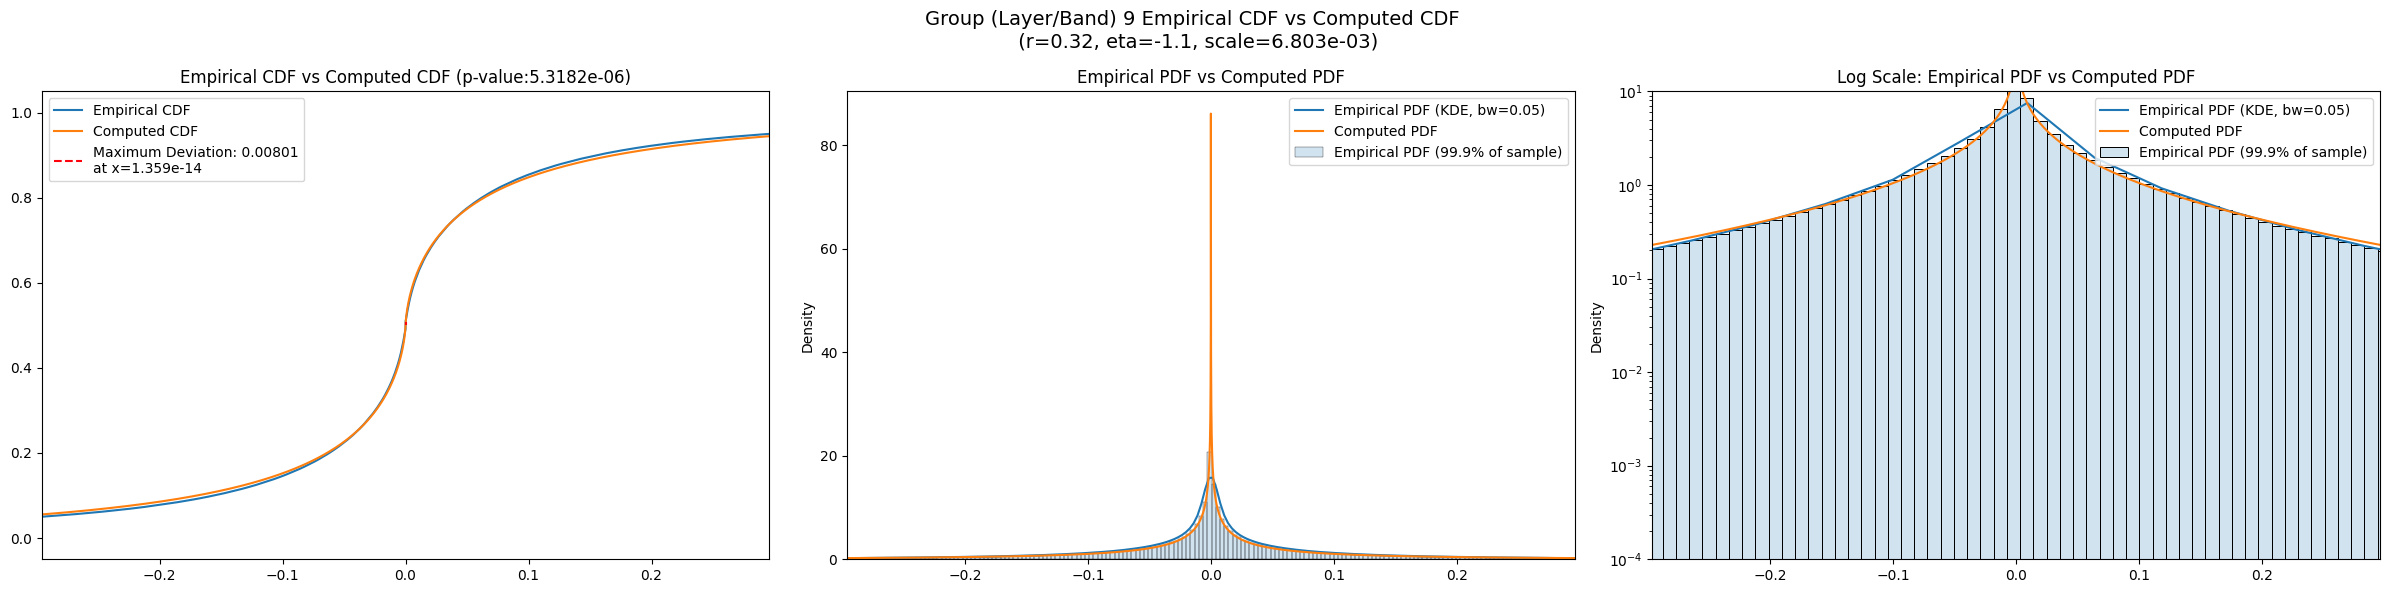

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,83.095370,67.855680,105.233030,71.455246,25.223500,201.95909,7225280.0,0.004810,0.3,-0.9,...,3.117170,0.071404,0.0,2.700100,0.045933,0.0,2.091050,0.046759,0.0,3.615699e-31
3,31.354197,25.858072,41.041767,80.993710,21.976780,296.53674,7225280.0,0.003786,0.5,-1.1,...,1.933070,0.074095,0.0,1.656920,0.049150,0.0,1.288220,0.050674,0.0,8.373121e-32
4,20.954084,16.831034,28.747263,110.533830,29.207600,413.64423,7225280.0,0.005774,0.4,-1.1,...,1.224100,0.081666,0.0,1.047410,0.057288,0.0,0.807792,0.058258,0.0,1.736235e-117
5,11.223501,8.338002,20.151466,398.395600,40.720660,1252.02470,28901120.0,0.005388,0.2,-0.9,...,0.689382,0.077730,0.0,0.596850,0.053256,0.0,0.456169,0.053261,0.0,6.420698e-265
6,3.142441,2.239151,6.361289,635.701300,43.524742,1749.60560,14450560.0,0.004946,0.2,-0.8,...,0.380015,0.073201,0.0,0.329354,0.048583,0.0,0.252251,0.048740,0.0,6.262814e-239
7,0.802050,0.597181,1.434407,389.129640,38.328990,1227.60790,14450560.0,0.004184,0.1,0.0,...,0.218373,0.070911,0.0,0.190275,0.045751,0.0,0.146391,0.045653,0.0,2.497164e-102
8,0.310199,0.229008,0.548214,370.670070,43.896652,1182.51530,14450560.0,0.003279,0.1,0.1,...,0.136282,0.068086,0.0,0.119393,0.042486,0.0,0.092182,0.042059,0.0,4.606950e-115
9,0.195227,0.138881,0.294189,220.667160,72.026210,636.45260,14676350.0,0.008010,0.2,-0.9,...,0.077459,0.078469,0.0,0.066523,0.053831,0.0,0.051369,0.054732,0.0,0.000000e+00


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.004810,0.000505,0.002213,0.071404,0.045933,0.046759
3,0.003786,0.000505,0.002236,0.074095,0.049150,0.050674
4,0.005774,0.000505,0.004319,0.081666,0.057288,0.058258
5,0.005388,0.000253,0.003246,0.077730,0.053256,0.053261
6,0.004946,0.000357,0.004359,0.073201,0.048583,0.048740
7,0.004184,0.000357,0.002849,0.070911,0.045751,0.045653
8,0.003279,0.000357,0.003022,0.068086,0.042486,0.042059
9,0.008010,0.000354,0.008010,0.078469,0.053831,0.054732


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,64.140961,0.002213,0.35,-1.00,6.541690e+00,75.0
3,23.750601,0.002236,0.40,-1.05,5.848411e+00,100.0
4,13.231064,0.004319,0.37,-1.10,2.756690e+00,200.0
5,9.012122,0.003246,0.12,-0.50,1.086366e-08,25.0
6,1.946082,0.004359,0.15,-0.60,1.126507e-06,100.0
7,0.596024,0.002849,0.12,-0.30,2.334655e-10,50.0
8,0.213295,0.003022,0.08,0.50,5.868366e-20,75.0
9,0.073537,0.008010,0.32,-1.10,6.803391e-03,275.0
